In [1]:
# The Holy Trinity
import torch
import numpy as np
import matplotlib.pyplot as plt

import copy

np.random.seed(123)

DutchField = [
    "#e60049", "#0bb4ff", "#50e991",
    "#e6d800", "#9b19f5", "#ffa300",
    "#dc0ab4", "#b3d4ff", "#00bfa0"
]

# Initialize Problem

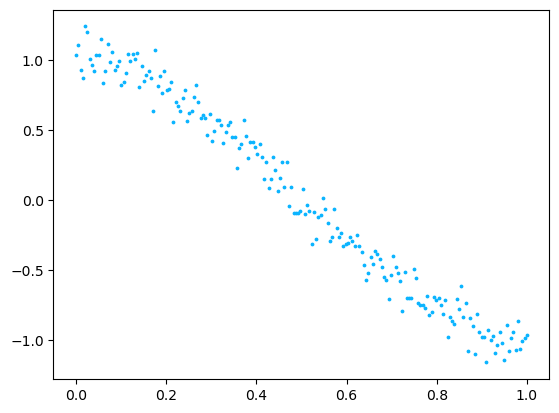

In [5]:
n_points = 200
x_array = torch.linspace(0, 1, n_points)
y_base = torch.cos(x_array * np.pi)
noise = torch.normal(0, 0.1, [n_points])
y_array = y_base + noise

fig = plt.figure()
ax = fig.subplots()

ax.scatter(x_array, y_array, c=DutchField[1], s=3)

# Polynomial Fit

Parametrize the estimation with a polynomial:
$$
\begin{align}
    \hat{y} &= \theta_0 + \theta_1 x + \theta_2 x^2 + \dots
\end{align}
$$

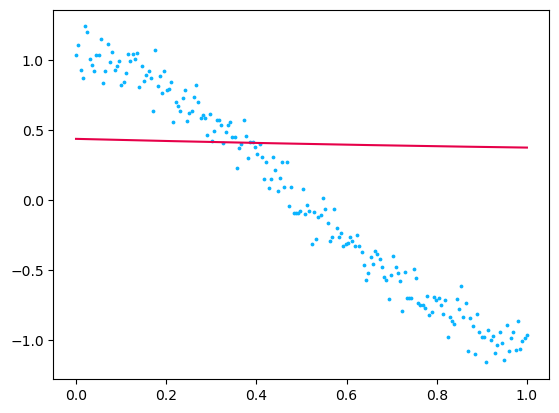

In [9]:
n_params = 3

# Initialize the vector theta with random values
theta = torch.normal(0.0, 1.0, [n_params])

# The function that returns \hat{y} from x and theta
def estimate_value(x, theta):
    output = torch.zeros(x.shape)
    for i_param in range(len(theta)):
        output += theta[i_param] * torch.pow(x, i_param)
        
    return output

# In order to take automatic gradients for theta, this is needed
theta.requires_grad_(True)


# Compute the squared error (hat(y) - y)^2
def get_error(x_data, y_data, theta):
    y_estimated = estimate_value(x_data, theta)
    error = y_estimated - y_data
    error_squared = torch.sum(torch.square(error))/len(theta)
    return error_squared


# Plot the result after the initialization, which is random
fig = plt.figure()
ax = fig.subplots()

ax.scatter(x_array, y_array, s=3, c=DutchField[1])
# We can not take gradients when plotting, so they are ignored inside this block
with torch.no_grad():
    ax.plot(x_array, estimate_value(x_array, theta), c=DutchField[0])

## Compute the gradient

The main point of using torch is that we can compute the gradient of an operation automatically.

In [14]:
# Initialize theta again
theta = torch.normal(0.0, 1.0, [3], requires_grad=True)

# Run an operation
error = get_error(x_array, y_array, theta)

# Propagate the gradients of the operation
error.backward()

# We can access the gradients from the initial variable
theta.grad

tensor([-10.5067,  12.1430,  12.7559])

## Vanilla Gradient Descent

We use this gradient information to make a simple training algorithm

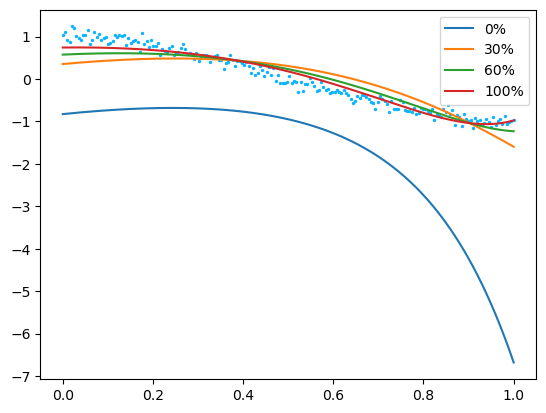

In [23]:
# We will use more parameters this time
n_params = 10
theta = torch.normal(0, 1.0, [n_params], requires_grad=True)

n_iterations = 12000

# Determines how fast theta changes from iteration to iteration
learning_rate = 0.0001

# This is just for saving theta at some moments during the training
saved_models = []
saved_iterations = [0, int(0.3 * n_iterations), int(0.6 * n_iterations)]

for i in range(n_iterations):
    if i in saved_iterations:
        saved_models.append(copy.copy(theta.detach().numpy()))

    # In each iteration: compute the error, obtain the gradient of it with respect to theta
    # and move theta in the opposite direction to the gradient
    error = get_error(x_array, y_array, theta)
    error.backward()
    delta = theta.grad

    # We desactivate gradient computation for updating theta, otherwise there are issues
    with torch.no_grad():
        theta -= learning_rate * delta

    # When we run "backward()", the gradient is added in the variable. We need to set it to
    # 0 for the next iteration
    theta.grad.zero_()
        
# Save the final model
saved_models.append(theta.detach().numpy())


# Plot the original data and the saved values of theta
fig = plt.figure()
ax = fig.subplots()
ax.scatter(x_array, y_array, s=2, c=DutchField[1])


legend_handles = []
legend_labels = ["0%", "30%", "60%", "100%"]

for model in saved_models:
    output = estimate_value(x_array, model)
    handle = ax.plot(x_array, output)[0]
    legend_handles.append(handle)

ax.legend(legend_handles, legend_labels)
    

## Using an Optimizer

Instead of manually changing $\theta$ in each iteration, we can use an optimizer to make it easier.

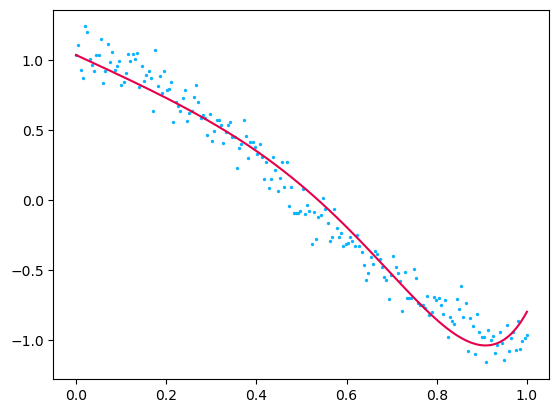

In [24]:
n_iterations = 200

theta = torch.normal(0, 1.0, [10], requires_grad=True)

# This will take care of using the gradients to update theta. We have
# to indicate which variables we are training. SGD is one option, but
# there are many more.
optimizer = torch.optim.SGD([theta], 0.001)

theta_array = np.zeros((n_iterations, n_params))


for i in range(2000):
    error = get_error(x_array, y_array, theta)
    error.backward()
    
    # This is equivalent to "theta -= learning_rate * theta.grad"
    optimizer.step()
    # This is equivalent to "theta.grad.zero_()"
    optimizer.zero_grad()
    

fig = plt.figure()
ax = fig.subplots()

ax.scatter(x_array, y_array, s=2, c=DutchField[1])

with torch.no_grad():
    ax.plot(x_array, estimate_value(x_array, theta), c=DutchField[0])

# Neural Networks

We can repeat the procedure using a neural network instead of the polynomial fit. The steps are basically the same.

The main differences are how the input and output are shaped, and how we define the parameters of the model (instead of $theta$, we have several matrices $W$ and $b$).

''

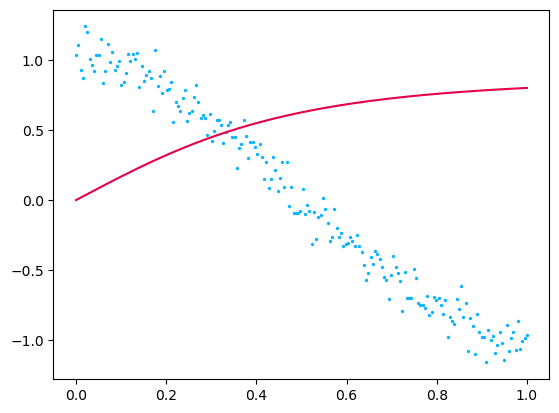

In [26]:
import neural_network

model = neural_network.NeuralNetwork([1, 3, 3, 1])

with torch.no_grad():
    # The neural network might be a little picky with how the input and the output are shaped,
    # so reshaping is common.
    y_estimation = model.compute(x_array.reshape([1, n_points])).reshape(n_points)

fig = plt.figure()
ax = fig.subplots()

ax.scatter(x_array, y_array, s=2, c=DutchField[1])


ax.plot(
    x_array, y_estimation, c=DutchField[0]
)
""


## Vanilla Gradient Descent

This is the same procedure as with the polynomial fit, only now the parameters are more complex than just a vector $\theta$.

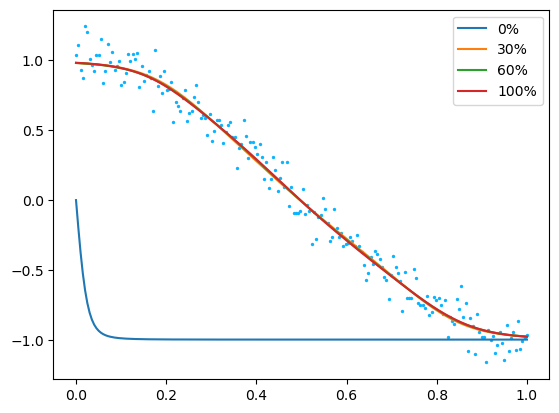

In [32]:
n_iterations = 8000

saved_models = []
saved_iterations = [0, int(0.3 * n_iterations), int(0.6 * n_iterations)]

def get_error(x_array, y_array, model):
    y_estimation = model.compute(x_array.reshape([1, n_points])).reshape(n_points)
    return (y_array - y_estimation).square().sum()


model = neural_network.NeuralNetwork([1, 3, 3, 3, 1])

learning_rate = 0.0001

for i in range(n_iterations):
    if i in saved_iterations:
        saved_models.append(copy.deepcopy(model))

    error = get_error(x_array, y_array, model)
    error.backward()
    
    # This method iterates over all the parameters (trainable variables) of the neural network, so we
    # can easily take the gradient and update them
    for variable in model.parameters():
        with torch.no_grad():
            variable -= variable.grad * learning_rate
        variable.grad.zero_()
        

saved_models.append(model)


legend_handles = []
legend_labels = ["0%", "30%", "60%", "100%"]

fig = plt.figure()
ax = fig.subplots()

ax.scatter(x_array, y_array, c=DutchField[1], s=2)

for model in saved_models:
    with torch.no_grad():
        y_estimated = model.compute(x_array.reshape([1, n_points])).reshape(n_points)

    handle = ax.plot(
        x_array,
        y_estimated
    )[0]
    
    legend_handles.append(handle)
    

ax.legend(legend_handles, legend_labels)

## Using an Optimizer

Again, we can use an optimizer to take care of the update of the parameters

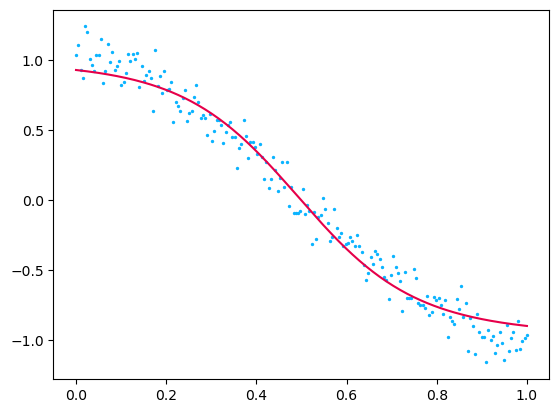

In [29]:
n_iterations = 2000

def get_loss(x_array, y_array, model):
    y_estimation = model.compute(x_array.reshape([1, n_points])).reshape(n_points)
    return (y_array - y_estimation).square().sum()


model = neural_network.NeuralNetwork([1, 3, 3, 1])

learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(n_iterations):
    loss = get_loss(x_array, y_array, model)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    

with torch.no_grad():
    y_estimated = model.compute(x_array.reshape([1, n_points])).reshape(n_points)

fig = plt.figure()
ax = fig.subplots()
ax.scatter(x_array, y_array, s=2, c=DutchField[1])

ax.plot(
    x_array,
    y_estimated,
    c=DutchField[0]
)

# Physics-informed Training

Finally, we can repeat the same process but also including physical constraints on the training. In our case, we can impose:
$$
    \frac{\partial \hat{y}^2}{\partial^2 x} + \pi\hat{y} = 0
$$

(-1.0, 1.0)

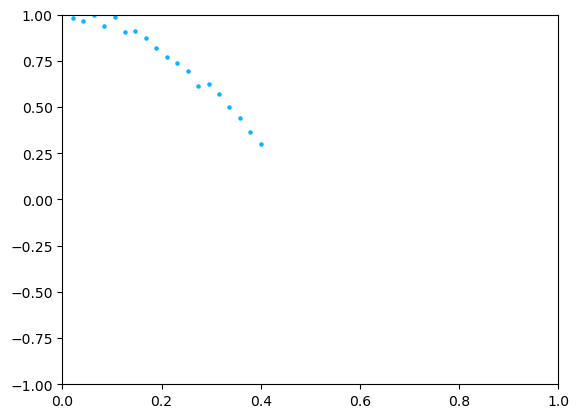

In [74]:
n_points = 20
x_array = torch.linspace(0, 0.4, n_points)
y_array = torch.cos(x_array * torch.pi) + torch.normal(0., 0.02, [n_points])

fig = plt.figure()
ax = fig.subplots()

ax.scatter(
    x_array,
    y_array,
    s=5, c=DutchField[1]
)
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)

In [132]:
model = neural_network.NeuralNetwork([1, 3, 3, 1])

n_physics = 50
x_physics = torch.linspace(0, 1, n_physics, requires_grad=True)

def get_data_loss(x_data, y_data, model):
    # Same as before
    y_estimation = model.compute(x_data.reshape([1, n_points])).reshape(n_points)
    error = y_data - y_estimation
    return error.square().mean()

def get_physics_loss(x_physics, model):
    # At the points x_physics, we compute the second derivative of y with respect to
    # x, and use the differential equation known to define the loss.
    y_estimation = model.compute(x_physics.reshape([1, n_physics])).reshape(n_physics)

    dy_dx = torch.autograd.grad(
        y_estimation,
        x_physics,
        create_graph=True,
        grad_outputs=torch.ones_like(x_physics)
    )[0]
    
    d2y_dx2 = torch.autograd.grad(
        dy_dx,
        x_physics,
        create_graph=True,
        grad_outputs=torch.ones_like(x_physics)
    )[0]

    error = (d2y_dx2 + torch.pi**2 * y_estimation)/torch.pi**2
    
    return error.square().mean()
    

def get_total_loss(x_data, y_data, x_physics, lamb, model):
    return get_data_loss(x_data, y_data, model) + lamb * get_physics_loss(x_physics, model)

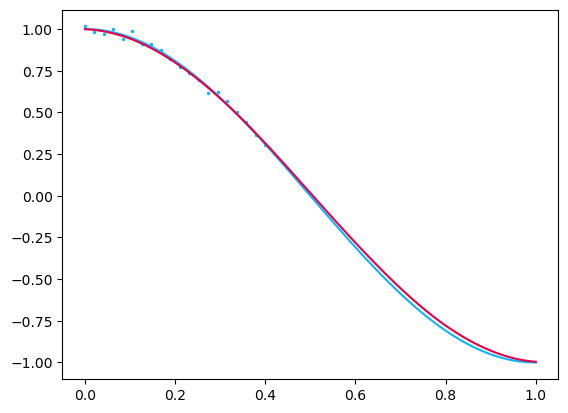

In [136]:
model = neural_network.NeuralNetwork([1, 3, 3, 1])

learning_rate = 0.01
x_physics = torch.linspace(0, 1, n_physics, requires_grad=True)
n_iterations = 20000

def get_lambda(k):
    # We usually start with no physics loss, and slowly increase it with
    # the number of iterations
    return (k/n_iterations)

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

for k in range(n_iterations):
    lamb = get_lambda(k)
    loss = get_total_loss(x_array, y_array, x_physics, lamb, model)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    

n_plotting = 100
x_plotting = torch.linspace(0, 1, n_plotting)
fig = plt.figure()
ax = fig.subplots()

ax.scatter(
    x_array,
    y_array,
    s=2, c=DutchField[1]
)

with torch.no_grad():
    y_estimation = model.compute(x_plotting.reshape([1, n_plotting])).reshape(n_plotting)

ax.plot(
    x_plotting, torch.cos(torch.pi * x_plotting), c=DutchField[1]
)
ax.plot(
    x_plotting, y_estimation, c=DutchField[0]
)